In [16]:
# pip install kagglehub scikit-image opencv-python matplotlib numpy
import kagglehub
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import remove_small_objects
from skimage.util import img_as_ubyte

plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["image.cmap"] = "gray"

print("Libraries Loaded Successfully")

Libraries Loaded Successfully


In [17]:
dataset_path = kagglehub.dataset_download(
    "andrewmvd/drive-digital-retinal-images-for-vessel-extraction"
)

print("Dataset location:")
print(dataset_path)

print("\nAvailable folders:")
print(os.listdir(dataset_path))

Dataset location:
C:\Users\sowmy\.cache\kagglehub\datasets\andrewmvd\drive-digital-retinal-images-for-vessel-extraction\versions\1

Available folders:
['DRIVE']


In [18]:
drive_path = os.path.join(dataset_path, "DRIVE")

print("DRIVE folder contents:")
print(os.listdir(drive_path))

print("\nTraining contents:")
print(os.listdir(os.path.join(drive_path, "training")))

print("\nTest contents:")
print(os.listdir(os.path.join(drive_path, "test")))

DRIVE folder contents:
['test', 'training']

Training contents:
['1st_manual', 'images', 'mask']

Test contents:
['images', 'mask']


Total training images: 20
Selected Image: 21_training.tif
Ground Truth: 21_manual1.gif


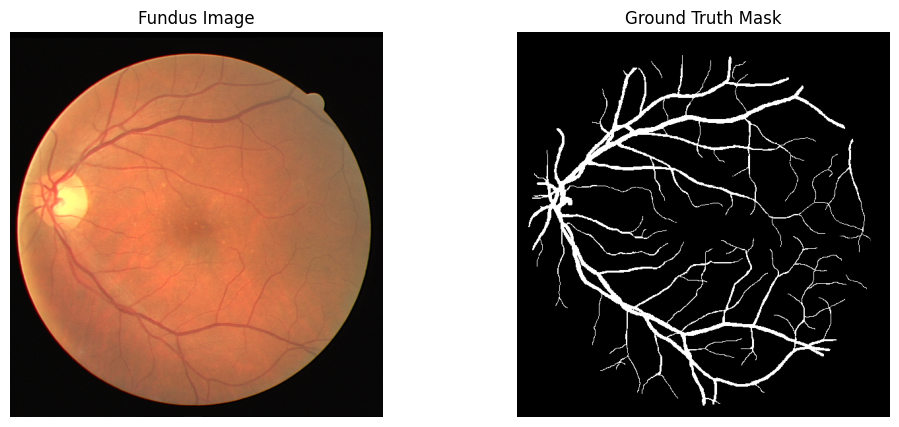

In [19]:
train_images_path = os.path.join(drive_path, "training", "images")
train_manual_path = os.path.join(drive_path, "training", "1st_manual")
mask_folder = os.path.join(drive_path, "training", "mask")

image_files = sorted(os.listdir(train_images_path))
manual_files = sorted(os.listdir(train_manual_path))

print("Total training images:", len(image_files))

image_path = os.path.join(train_images_path, image_files[0])
manual_path = os.path.join(train_manual_path, manual_files[0])
mask_files = sorted(os.listdir(mask_folder))

print("Selected Image:", image_files[0])
print("Ground Truth:", manual_files[0])

retinal_image = cv2.imread(image_path)
retinal_rgb = cv2.cvtColor(retinal_image, cv2.COLOR_BGR2RGB)

ground_truth = cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(retinal_rgb)
plt.title("Fundus Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ground_truth)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.show()

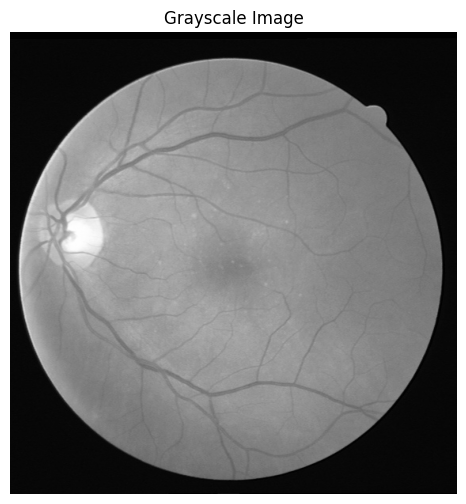

Shape: (584, 565)
Type: uint8


In [20]:
gray_image = cv2.cvtColor(retinal_rgb, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image)
plt.title("Grayscale Image")
plt.axis("off")
plt.show()

print("Shape:", gray_image.shape)
print("Type:", gray_image.dtype)

In [25]:
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ground_truth = cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

fov = mask > 0
gt = ground_truth > 0

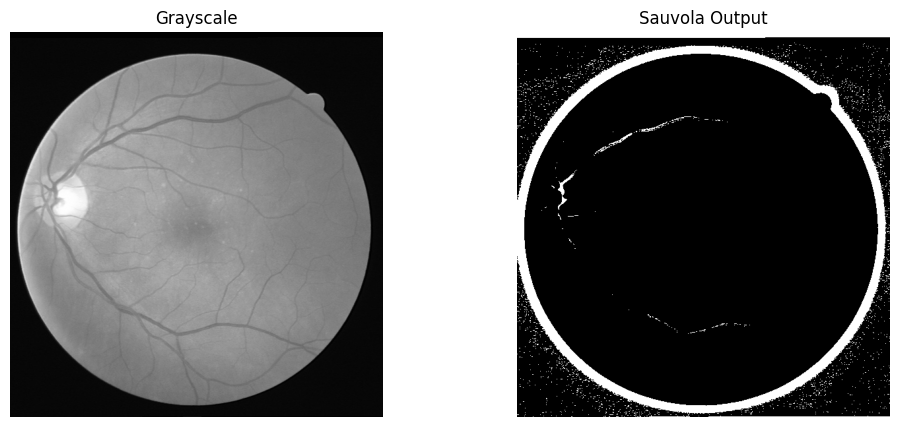

In [26]:
window_size = 25

sauvola_thresh = threshold_sauvola(gray_image, window_size=window_size)

sauvola_binary = gray_image < sauvola_thresh

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(gray_image)
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_as_ubyte(sauvola_binary))
plt.title("Sauvola Output")
plt.axis("off")

plt.show()

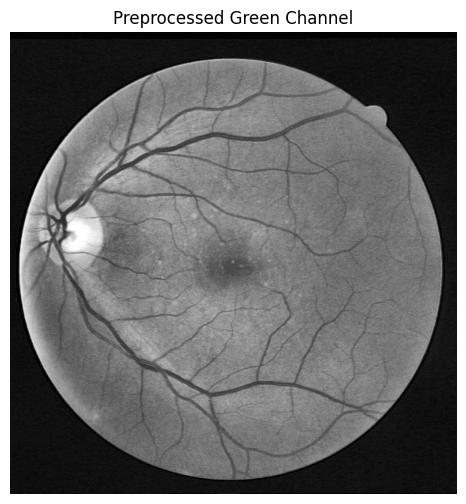

In [27]:

# Read image again safely
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

green = image_rgb[:, :, 1]

# Contrast Enhancement (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
green_clahe = clahe.apply(green)

green_norm = green_clahe / 255.0

plt.imshow(green_clahe)
plt.title("Preprocessed Green Channel")
plt.axis("off")
plt.show()

In [28]:
window_size = 25
k_niblack = -0.2

thresh_niblack = threshold_niblack(green_norm, window_size=window_size, k=k_niblack)
niblack_binary = green_norm < thresh_niblack

niblack_clean = remove_small_objects(niblack_binary, min_size=80)
niblack_final = niblack_clean & fov

C:\Users\sowmy\AppData\Local\Temp\ipykernel_14264\2521215383.py:7: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  niblack_clean = remove_small_objects(niblack_binary, min_size=80)


In [29]:
k_sauvola = 0.2

thresh_sauvola = threshold_sauvola(green_norm, window_size=window_size, k=k_sauvola)
sauvola_binary = green_norm < thresh_sauvola

sauvola_clean = remove_small_objects(sauvola_binary, min_size=80)
sauvola_final = sauvola_clean & fov

C:\Users\sowmy\AppData\Local\Temp\ipykernel_14264\1625073588.py:6: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  sauvola_clean = remove_small_objects(sauvola_binary, min_size=80)


In [30]:
def sensitivity_score(gt, pred):
    TP = np.sum((gt == 1) & (pred == 1))
    FN = np.sum((gt == 1) & (pred == 0))
    return TP / (TP + FN + 1e-8)

gt_flat = (gt & fov).flatten()
niblack_flat = niblack_final.flatten()
sauvola_flat = sauvola_final.flatten()

sens_niblack = sensitivity_score(gt_flat, niblack_flat)
sens_sauvola = sensitivity_score(gt_flat, sauvola_flat)

print("Niblack Sensitivity:", sens_niblack)
print("Sauvola Sensitivity:", sens_sauvola)

Niblack Sensitivity: 0.9193914807298501
Sauvola Sensitivity: 0.4140770791073371


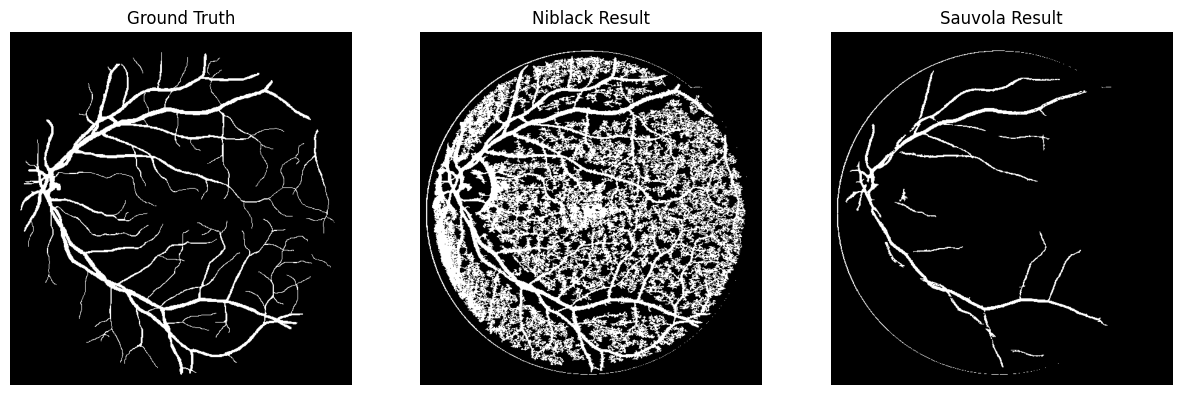

In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gt & fov)
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(niblack_final)
plt.title("Niblack Result")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(sauvola_final)
plt.title("Sauvola Result")
plt.axis("off")

plt.show()

In [32]:
results_folder = "Retinal_Project_Submission"
os.makedirs(results_folder, exist_ok=True)

cv2.imwrite(os.path.join(results_folder, "niblack.png"),
            img_as_ubyte(niblack_final))

cv2.imwrite(os.path.join(results_folder, "sauvola.png"),
            img_as_ubyte(sauvola_final))

with open(os.path.join(results_folder, "metrics.txt"), "w") as f:
    f.write("Retinal Vessel Extraction\n")
    f.write("Comparison: Sauvola vs Niblack\n\n")
    f.write("Niblack Sensitivity: " + str(sens_niblack) + "\n")
    f.write("Sauvola Sensitivity: " + str(sens_sauvola) + "\n")

print("Submission files saved.")

Submission files saved.
